In [1]:
import numpy as np
import sympy as sp
import matplotlib.animation as animation 
import matplotlib.pyplot as plt 
from scipy.integrate import odeint,ode
from scipy.optimize import fsolve

In [2]:
l0, l1, l2, w, = sp.symbols('l0,l1,l2,w')

Ibx,Iby,Ibz = sp.symbols('I_bx,I_by,I_bz')
Itx,Ity,Itz = sp.symbols('I_tx,I_ty,I_tz')
Icx,Icy,Icz = sp.symbols('I_cx,I_cy,I_cz')
mb,mt,mc = sp.symbols('m_b,m_t,m_c')

P = sp.symbols('P')
g = 9.81
"""Left leg variables"""
plh, tlh, psilh, tlk, plhd, tlhd, psilhd, tlkd = sp.symbols('phi_lh,theta_lh,psi_lh,theta_lk,phidot_lh,thetadot_lh,psidot_lh,thetadot_lk')
plhddot, tlhddot, psilhddot, tlkddot = sp.symbols('phiddot_lh,thetaddot_lh,psiddot_lh,thetaddot_lk')

"""Right leg varibales"""
prh, trh, psirh, trk, prhd, trhd, psirhd, trkd = sp.symbols('phi_rh,theta_rh,psi_rh,theta_rk,phidot_rh,thetadot_rh,psidot_rh,thetadot_rk')
prhddot, trhddot, psirhddot, trkddot = sp.symbols('phiddot_rh,thetaddot_rh,psiddot_rh,thetaddot_rk')

"""Torso variables"""
p, t, psi, x,y,z, pd, td, psid, xd,yd,zd = sp.symbols('phi,theta,psi,x,y,z,phidot,thetadot,psidot,xdot,ydot,zdot')
pddot, tddot, psiddot, xddot,yddot,zddot = sp.symbols('phiddot,thetaddot,psiddot,xddot,yddot,zddot')

q = sp.Matrix([p, t, psi, x,y,z,plh, tlh, psilh, tlk,prh, trh, psirh, trk])
qdot = sp.Matrix([pd, td, psid, xd,yd,zd , plhd, tlhd, psilhd, tlkd, prhd, trhd, psirhd, trkd])
qddot = sp.Matrix([pddot, tddot, psiddot, xddot,yddot,zddot,plhddot, tlhddot, psilhddot, tlkddot,prhddot, trhddot, psirhddot, trkddot])

def i_1Ti(phi,phid,u,r):
    """
        @phi: Angle of rotation.
        @u : Unit base along which rotation is happening.
        @r : Position vector of joint in world frame.
    """
    
    ux,uy,uz = u
    R = sp.eye(3,3)
    cth = sp.cos(phi)
    sth = sp.sin(phi)
    vth = 1 - cth
    R[0,0] = (ux**2)*vth + cth
    R[0,1] = ux*uy*vth-(uz*sth)
    R[0,2] = ux*uz*vth+(uy*sth)
    R[1,0] = ux*uy*vth + (uz*sth)
    R[1,1] = ((uy**2)*vth) + cth
    R[1,2] = uy*uz*vth - (ux*sth)
    R[2,0] = ux*uz*vth - (uy*sth)
    R[2,1] = uy*uz*vth + (ux*sth)
    R[2,2] = ((uz**2)*vth) + cth
    I = sp.eye(3,3)
    
    R1 = R.col_insert(3,(I-R)@r.T)
    tmp = sp.Matrix([0,0,0,1]).T
    
    T = R1.col_join(tmp)
    omega = phid*sp.Matrix(u)
    return T, R, omega

In [3]:
"""For Right Leg """
print('"""For Right Leg """')
T12r,R12r,omega12r = i_1Ti(psirh,psirhd,np.array([0,0,-1]),sp.Matrix([[0,-w,0]]))
T23r,R23r,omega23r = i_1Ti(prh,prhd,np.array([-1,0,0]),sp.Matrix([[0,-w,0]]))
T34r,R34r,omega34r = i_1Ti(trh,trhd,np.array([0,-1,0]),sp.Matrix([[0,-w,0]]))
T45r,R45r,omega45r = i_1Ti(trk,trkd,np.array([0,-1,0]),sp.Matrix([[0,-w,-l1]]))

T14r = T12r@T23r@T34r
T15r = T12r@T23r@T34r@T45r
T12r.shape

"""For Right Leg """


(4, 4)

In [4]:
"""For Left Leg"""
print('"""For Left Leg"""')
T12l,R12l,omega12l = i_1Ti(psilh,psilhd,np.array([0,0,1]),sp.Matrix([[0,w,0]]))
T23l,R23l,omega23l = i_1Ti(plh,plhd,np.array([1,0,0]),sp.Matrix([[0,w,0]]))
T34l,R34l,omega34l = i_1Ti(tlh,tlhd,np.array([0,-1,0]),sp.Matrix([[0,w,0]]))
T45l,R45l,omega45l = i_1Ti(tlk,tlkd,np.array([0,-1,0]),sp.Matrix([[0,w,-l1]]))

T14l = T12l@T23l@T34l
T15l = T12l@T23l@T34l@T45l
T15l.shape

"""For Left Leg"""


(4, 4)

In [5]:
""" For Torso"""

'''World Frame'''
T01 = sp.Matrix([[1, 0, 0, x],
                 [0, 1, 0, y],
                 [0, 0, 1, z], 
                 [0, 0, 0, 1]])
R01 = sp.Matrix([[1,0,0],[0,1,0],[0,0,1]])
T12,R12,omega12 = i_1Ti(p,pd,np.array([1,0,0]),sp.Matrix([[0,0,0]]))
T23,R23,omega23 = i_1Ti(t,td,np.array([0,1,0]),sp.Matrix([[0,0,0]]))
T34,R34,omega34 = i_1Ti(psi,psid,np.array([0,0,1]),sp.Matrix([[0,0,0]]))

T04 = T01@T12@T23@T34
T04.shape

(4, 4)

In [6]:
"""Position vectors for Torso"""
P_h = T04@sp.Matrix([0,0,l0,1])
P_h = sp.Matrix(P_h[:3])
P_h.shape

(3, 1)

In [7]:
"""Position Vectors for Left Leg"""
P_lh = T04@T14l@sp.Matrix([0,w,0,1])
P_lk = T04@T15l@sp.Matrix([0,w,-l1,1])
P_la = T04@T15l@sp.Matrix([0,w,-(l1+l2),1])
P_la.shape

(4, 1)

In [8]:
"""Position Vectors for Right Leg"""
P_rh = T04@T14r@sp.Matrix([0,-w,0,1])
P_rk = T04@T15r@sp.Matrix([0,-w,-l1,1])
P_ra = T04@T15r@sp.Matrix([0,-w,-(l1+l2),1])
P_ra.shape

(4, 1)

In [9]:
"""Position of COM"""
print('"""Position of COM"""')
com_b = T04@sp.Matrix([0,0,0.5*l0,1])
com_lt = T04@T14l@sp.Matrix([0,w,-0.5*l1,1])
com_lc = T04@T15l@sp.Matrix([0,w,-(l1+0.5*l2),1])
com_rt = T04@T14r@sp.Matrix([0,-w,-0.5*l1,1])
com_rc = T04@T15r@sp.Matrix([0,-w,-(l1+0.5*l2),1])
com_b.shape

"""Position of COM"""


(4, 1)

In [10]:
"""Angular velocity in body frame"""

omegaB_2 = omega12
omegaB_3 = omega23 + R23.T@omegaB_2
omegaB_4 = omega34 + R34.T@omegaB_3

"""Angular velocity for left leg"""

omegaB_1l = omega12l + R12l.T@omegaB_4
omegaB_2l = omega23l + R23l.T@omegaB_1l
omegaB_3l = omega34l + R34l.T@omegaB_2l
omegaB_4l = omega45l + R45l.T@omegaB_3l

"""Angular velocity for right leg"""
omegaB_1r = omega12r + R12r.T@omegaB_4
omegaB_2r = omega23r + R23r.T@omegaB_1r
omegaB_3r = omega34r + R34r.T@omegaB_2r
omegaB_4r = omega45r + R45r.T@omegaB_3r
print('"""Angular velocity"""')

"""Angular velocity"""


In [11]:
qdot_diag = sp.diag(pd, td, psid, xd,yd,zd , plhd, tlhd, psilhd, tlkd, prhd, trhd, psirhd, trkd)
qddot_diag = sp.diag(pddot, tddot, psiddot, xddot,yddot,zddot,plhddot, tlhddot, psilhddot, tlkddot,prhddot, trhddot, psirhddot, trkddot)
v_b = com_b.jacobian(q)@qdot
v_lt = com_lt.jacobian(q)@qdot
v_lc = com_lc.jacobian(q)@qdot
v_rt = com_rt.jacobian(q)@qdot
v_rc = com_rc.jacobian(q)@qdot
print('"""linear velocity"""')

"""linear velocity"""


In [12]:
v_lh = P_lh.jacobian(q)@qdot
v_rh = P_rh.jacobian(q)@qdot
v_rh.shape

(4, 1)

In [13]:
Ib = sp.diag(Ibx, Iby, Ibz)
It = sp.diag(Itx, Ity, Itz)
Ic = sp.diag(Icx, Icy, Icz)


T = 0.5*(mb*(v_b.T@v_b) +mt*(v_rt.T@v_rt) + mc*(v_rc.T@v_rc) + mt*(v_lt.T@v_lt)+ mc*(v_lc.T@v_lc) \
                  +(omegaB_4.T@Ib@omegaB_4) + (omegaB_3l.T@It@omegaB_3l) \
                   +(omegaB_4l.T@Ic@omegaB_4l) + (omegaB_4r.T@Ic@omegaB_4r))

V = sp.Matrix([mb*g*com_b[2] +mt*g*com_rt[2]+ mt*g*com_lt[3]+ mc*g*com_lc[2] + mc*g*com_rc[3]])

L = T - V
L.shape

(1, 1)

In [14]:
dLdqdot = L.jacobian(qdot)
(dLdqdot).shape

(1, 14)

In [15]:
dt_dLdqdot = sp.Matrix.diagonal(dLdqdot.jacobian(q))@qdot_diag + sp.Matrix.diagonal(dLdqdot.jacobian(qdot))@qddot_diag

dt_dLdqdot.shape

(1, 14)

In [16]:
dLdq = L.jacobian(q)
# dLdq.shape

EOM = dt_dLdqdot - dLdq
EOM.shape

(1, 14)

In [17]:
M = EOM.jacobian(qddot)
M.shape

(14, 14)

In [18]:
B = EOM.subs({pddot:0, tddot:0, psiddot:0, xddot:0,yddot:0,zddot:0 , plhddot:0, tlhddot:0, psilhddot:0, tlkddot:0, prhddot:0, trhddot:0, psirhddot:0, trkddot:0})
B.shape

(1, 14)

In [19]:
P_ra1 = sp.Matrix(P_ra[:3])
P_la1 = sp.Matrix(P_la[:3])
J_r = P_ra1.jacobian(q)
J_l = P_la1.jacobian(q)

Jdot_l = (sp.Matrix([J_l.row(0)]).jacobian(q)@qdot).T
Jdot_r = (sp.Matrix([J_r.row(0)]).jacobian(q)@qdot).T

for i in range(1,3):
    Jdot_l = Jdot_l.row_insert(i,(sp.Matrix([J_l.row(i)]).jacobian(q)@qdot).T)
    Jdot_r = Jdot_r.row_insert(i,(sp.Matrix([J_r.row(i)]).jacobian(q)@qdot).T)
     
Jdot_l.shape

(3, 14)

In [20]:
class parameters:
    def __init__(self):
        self.l0, self.l1,self.l2, self.w = 1, 0.5, 0.5, 0.1
        self.mb, self.mt,self.mc = 70,10,5
        self.Ibx,self.Iby,self.Ibz = 5,3,2
        self.Itx, self.Ity, self.Itz = 1,0.3,2
        self.Icx,self.Icy,self.Icz = 0.5,0.15,1
        """ torso params"""
        self.p, self.t, self.psi = 0,0,0
        self.pd, self.td, self.psid = 0,0,0
        self.x,self.y,self.z = 0,0,0
        self.xd,self.yd,self.zd = 0,0,0
        """left leg params"""
        self.plh, self.tlh, self.psilh, self.tlk = 0,0,0,-1
        self.plhd, self.tlhd, self.psilhd, self.tlkd = 0,0,0,0
        """right leg params"""
        self.prh, self.trh, self.psirh, self.trk = 0,0,0,-1
        self.prhd, self.trhd, self.psirhd, self.trkd = 0, 0, 0, 0 
        
        self.M = self.mb+2*self.mt+2*self.mc
        self.L = self.l1+self.l2
    
    def set_equations(self,M,B,J_r,J_l,Jdot_r,Jdot_l,P_h,P_rh,P_rk, P_ra, P_lh, P_lk, P_la,v_lh,v_rh):
        """converting sympy variables to numpy functions for better computation."""
        
        M = M.subs({l0:self.l0, l1:self.l1,l2:self.l2, w:self.w,\
                    mb:self.mb, mt:self.mt,mc:self.mc,\
                    Ibx:self.Ibx,Iby:self.Iby,Ibz:self.Ibz,\
                    Itx:self.Itx,Ity:self.Ity,Itz:self.Itz,\
                    Icx:self.Icx,Icy:self.Icy,Icz:self.Icz})
        
        B = B.subs({l0:self.l0, l1:self.l1,l2:self.l2, w:self.w,\
                    mb:self.mb, mt:self.mt,mc:self.mc,\
                    Ibx:self.Ibx,Iby:self.Iby,Ibz:self.Ibz,\
                    Itx:self.Itx,Ity:self.Ity,Itz:self.Itz,\
                    Icx:self.Icx,Icy:self.Icy,Icz:self.Icz})
        
        J_r = J_r.subs({l1:self.l1,l2:self.l2, w:self.w})
        J_l = J_l.subs({l1:self.l1,l2:self.l2, w:self.w})
        
        Jdot_r = Jdot_r.subs({l1:self.l1,l2:self.l2, w:self.w})
        Jdot_l = Jdot_l.subs({l1:self.l1,l2:self.l2, w:self.w})
        
        P_h = P_h.subs({l0: self.l0})
        
        P_lh = P_lh.subs({w: self.w, l1: self.l1, l2: self.l2})
        P_lk = P_lk.subs({w: self.w, l1: self.l1, l2: self.l2})
        P_la = P_la.subs({w: self.w, l1: self.l1, l2: self.l2})

        
        P_rh = P_rh.subs({w: self.w, l1: self.l1, l2: self.l2})
        P_rk = P_rk.subs({w: self.w, l1: self.l1, l2: self.l2})
        P_ra = P_ra.subs({w: self.w, l1: self.l1, l2: self.l2})
        
        v_lh = v_lh.subs({w: self.w, l1: self.l1, l2: self.l2})
        v_rh = v_rh.subs({w: self.w, l1: self.l1, l2: self.l2})
        
 
        self.M_num = sp.lambdify([p, t, psi,plh, tlh, psilh, tlk,\
                             prh, trh, psirh, trk],M)
        
        self.B_num = sp.lambdify([p, t, psi,plh, tlh, psilh, tlk,                           
                                  prh, trh, psirh, trk,
                                  pd,td,psid,
                                  xd,yd,zd,
                                  plhd, tlhd, psilhd, tlkd,                           
                                  prhd, trhd, psirhd, trkd], B)
        
        self.J_r_num = sp.lambdify([p, t, psi,prh, trh, psirh, trk], J_r)
        self.J_l_num = sp.lambdify([p, t, psi,plh, tlh, psilh, tlk], J_l)
        
        self.Jdot_r_num = sp.lambdify([p, t, psi, prh, trh, psirh, trk, pd, td, psid, prhd, trhd, psirhd, trkd],Jdot_r)
        
        self.Jdot_l_num = sp.lambdify([p, t, psi, plh, tlh, psilh, tlk, pd, td, psid, plhd, tlhd, psilhd, tlkd],Jdot_l)
        
        self.P_h_num = sp.lambdify([x,y,z,p,t,psid],P_h)
        self.P_rh_num = sp.lambdify([x,y,z,p,t,psi, prh, trh, psirh, trk],P_rh)
        self.P_rk_num = sp.lambdify([x,y,z,p,t,psi, prh, trh, psirh, trk],P_rk)
        self.P_ra_num = sp.lambdify([x,y,z,p,t,psi, prh, trh, psirh, trk],P_ra)
        
        self.P_lh_num = sp.lambdify([x,y,z,p,t,psi,plh,tlh, psilh, tlk],P_lh)
        self.P_lk_num = sp.lambdify([x,y,z,p,t,psi,plh,tlh, psilh, tlk],P_lk) 
        self.P_la_num = sp.lambdify([x,y,z,p,t,psi,plh,tlh, psilh, tlk],P_la)
        
        self.v_lh_num = sp.lambdify([p, t, psi, plh, tlh, psilh, tlk,pd,td,psid,xd,yd,zd,plhd,tlhd,psilhd],v_lh)
        self.v_rh_num = sp.lambdify([p, t, psi, prh, trh, psirh, trk,pd,td,psid,xd,yd,zd,prhd,trhd,psirhd],v_rh)
#         print(self.P_h_num(0.3,0.2,0.2,0.3, 0.2, 0.2)) 
        
p1 = parameters()
p1.set_equations(M,B,J_r,J_l,Jdot_r,Jdot_l,P_h,P_rh,P_rk, P_ra, P_lh, P_lk, P_la,v_lh,v_rh)

In [21]:
p1.v_rh_num(10,4,6,10,7,6,7,3,2,10,10,6,4,6,8,1)
# p1.P_h_num(0,0,0,0,0,0)

array([[9.33009835],
       [6.39996029],
       [3.78012159],
       [0.        ]])

In [121]:
class traj_gen:
    def __init__(self,t0,tf,q0,qf,q0dot,qfdot,q0ddot,qfddot):
        self.t0 = t0
        self.tf = tf
        self.q0 = q0
        self.qf = qf 
        self.q0dot = q0dot
        self.qfdot = qfdot
        self.q0ddot = q0ddot
        self.qfddot = qfddot
    
    def set_param(self,q0_):
        self.q0 = q0_
        
    def getb(self):
        t0,tf = self.t0,self.tf
        A = np.array([[1,t0,t0**2,t0**3,t0**4,t0**5],
                       [1,tf,tf**2,tf**3,tf**4,tf**5],
                       [0,1,2*t0,3*t0**2,4*t0**3,5*t0**4],
                       [0,1,2*tf,3*tf**2,4*tf**3,5*tf**4],
                       [0,0,2,6*t0,12*t0**2,20*t0**3],
                       [0,0,2,6*tf,12*tf**2,20*tf**3]])
        C = np.vstack((self.q0,self.qf,self.q0dot,self.qfdot,self.q0ddot,self.qfddot))
        B = np.linalg.inv(A)@C
        
        return B
    
    def get_q(self,t):
        T1 = np.array([[1,t,t**2,t**3,t**4,t**5]])
        T2 = np.array([[0,1,2*t,3*t**2,4*t**3,5*t**4]])
        T3 = np.array([[0,0,2,6*t,12*t**2,20*t**3]])
        B = np.squeeze(self.getb())
        q = B.T@T1.T
        qdot = B.T@T2.T
        qddot = B.T@T3.T
        return q, qdot, qddot
    

    
# ankle_motion = deg2rad([-7.5 10 10 5 0 -10 -7.5])
# knee_motion = deg2rad([10, -5, 2.5, -10, -10, 15, 10])
# hip_motion = deg2rad([-10, -7.5, -15, 10, 15, 10,-10])

knee_angle = -1
step_angle = 0.345
"""Intitial and final conditions for left swing leg"""
q0 = np.array([0,0,0,  0,         0,0, knee_angle,           0])
qf = np.array([0,0,0,  0,step_angle,0,          0,           0])
q0dot = np.array([0,0,0,0,0,0,0,0])
qfdot = np.array([0,0,0,0,0,0,0,0])
q0ddot = np.array([0,0,0,0,0,0,0,0])
qfddot = np.array([0,0,0,0,0,0,0,0])
c1  = traj_gen(0,0.2,q0,qf,q0dot,qfdot,q0ddot,qfddot)
"""initial and final conditions for right swing leg"""
q01 = np.array([0,0,0,  0,         0,         0, 0,           0])
qf1 = np.array([0,0,0,  0,         0,0*step_angle, 0,  knee_angle])

c2 = traj_gen(0.0,0.2,q01,qf1,q0dot,qfdot,q0ddot,qfddot)
# c1.getb()[0]
# c1.get_q(0.013352200294876845)
print("traj gen")

traj gen


In [ ]:
class Humanoid(parameters):
    def __init__(self):
        super().__init__()

        self.tlh = 0.0
        self.trh = 0.0
    
        self.tlk = -1
        self.trk = 0.0
        
        self.xd = 1.2
    
        self.td = 1.0
        
#         self.prh =  -0.029247773468329
#         self.prhd = 0.054577886084082
        
#         self.trh = -0.001551040824746
#         self.trhd = -1.029460778006675
        
#         self.psirh = 0.054690088280553
#         self.psirhd = 0.559306810759302
        
        self.define_Z0()
        
        self.leg = "left"
        
        self.t_start = 0.0
        self.t_end = 0.2
    
        self.impulse = 0.018*self.M*np.sqrt(9.18*self.L)
        
        self.err = np.array([[0,0,0,0,0,0,0,0]])
        self.q_data = np.array([[0,0,0,0,0,0,0,0]])
    
    def define_Z0(self):
        self.Z0 = np.array([self.p, self.t, self.psi,\
                            self.x, self.y, self.z,\
                            self.plh, self.tlh, self.psilh, self.tlk,\
                            self.prh, self.trh, self.psirh, self.trk,\
                            self.pd, self.td, self.psid,\
                            self.xd, self.yd, self.zd,\
                            self.plhd, self.tlhd, self.psilhd, self.tlkd,\
                            self.prhd, self.trhd, self.psirhd, self.trkd\
                           ],dtype='float')
        
        
        self.Z = np.array([self.Z0])
        
        print("initial param:",self.Z)
        
    def set_equations(self,M_num,B_num,J_l_num,J_r_num,Jdot_l_num,Jdot_r_num,P_lh, P_rh, P_lk, P_rk, P_la,P_ra,v_lh,v_rh):
        self.M_num = M_num
        self.B_num = B_num
        
        self.J_l_num = J_l_num
        self.J_r_num = J_r_num
        self.Jdot_l_num = Jdot_l_num
        self.Jdot_r_num = Jdot_r_num
        
        self.P_lh = P_lh
        self.P_rh = P_rh
        self.P_lk = P_lk
        self.P_rk = P_rk
        self.P_la = P_la
        self.P_ra = P_ra
        
        self.v_lh = v_lh
        self.v_rh = v_rh
        
        if self.leg == "left":
            P = self.P_rh(self.x,self.y,self.z,self.p,self.t,self.psi,self.prh,self.trh, self.psirh, self.trk)
            Vh = self.v_rh(self.p, self.t, self.psi, self.prh, self.trh, self.psirh, self.trk, self.pd, self.td,self.psid,self.xd,self.yd,self.zd,self.prhd,self.trhd,self.psirhd)
        else:
            P = self.P_lh(self.x,self.y,self.z,self.p,self.t,self.psi,self.plh,self.tlh, self.psilh, self.tlk)
            Vh = self.v_lh(self.p, self.t, self.psi, self.plh, self.tlh, self.psilh, self.tlk, self.pd, self.td,self.psid,self.xd,self.yd,self.zd,self.plhd,self.tlhd,self.psilhd)
        
        self.x = P[0]
        self.y = P[1]
        self.z = P[2]
        
        self.xd,self.yd, self.zd = Vh[0], Vh[1], Vh[2]
        
        self.define_Z0()
        
    def get_T(self,t,leg, A_, b_):
        
        """Gives BT part of the equation / calculates torque required at each working joint."""
        """A_,b_ are Estimated parameters of the system """
        B1 = np.zeros((6,8))
        B2 = np.eye((8))
        B3 = np.zeros((3,8))
        B = np.concatenate((B1,B2,B3))
        
        
        S_R = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
        
        S_L = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])
        
        if t <= 0.2:
            if leg == "left":
                S = S_L
                self.q_des, self.qdot_des, self.qddot_des = c1.get_q(t)
            else:
                S = S_R
                self.q_des, self.qdot_des, self.qddot_des = c2.get_q(t)
        else:
            if leg == "left":
                S = S_L
            else:
                S = S_R
        
        
        Kd = np.eye((8))*10
        Kp = np.eye((8))*100
        
        v = self.qddot_des + Kd@(self.qdot_des.T - self.qdot).T + Kp@(self.q_des.T -self.q).T 
        
        self.err = np.append(self.err, ((self.q_des.T - self.q)),axis=0)
        self.q_data = np.append(self.q_data, ([self.q]),axis=0)
        T = np.linalg.pinv(S@np.linalg.inv(A_)@B)@(v - S@np.linalg.inv(A_)@b_)
        
        return B[:14]@T 
        
    def collision(self):
        """z coordinate of left ankle and right ankle should be equal for collision and switching of legs"""
        
        p,t,psi,x,y,z,plh, tlh, psilh, tlk,prh, trh, psirh, trk = self.z[:14]
        if self.start:
            return True
        else:
            
            if (np.abs(self.P_la(x,y,z,p,t,psi,plh,tlh, psilh, tlk)[2] - self.P_ra(x,y,z,p,t,psi,prh, trh, psirh, trk)[2]) > 1e-12):
                return True
            else:
                print("Collision occured")
                return False
    
    def find_temp(self,z):
        self.M_temp = self.M_num(z[0],z[1],z[2],z[6],z[7],z[8],z[9],z[10],z[11],z[12],z[13])
        self.B_temp = self.B_num(z[0],z[1],z[2],z[6],z[7],z[8],z[9],z[10],z[11],z[12],z[13],z[14],z[15],z[16],z[17],z[18],z[19],z[20],z[21],z[22],z[23],z[24],z[25],z[26],z[27])
        
        self.Jdot_r_temp = self.Jdot_r_num(z[0],z[1],z[2],z[10],z[11],z[12],z[13],z[14],z[15],z[16],z[24],z[25],z[26],z[27])
        self.Jdot_l_temp = self.Jdot_l_num(z[0],z[1],z[2], z[6], z[7], z[8], z[9],z[14],z[15],z[16],z[20],z[21],z[22],z[23])
        
        self.J_l_temp = self.J_l_num(z[0],z[1],z[2],z[6],  z[7], z[8], z[9])
        self.J_r_temp = self.J_r_num(z[0],z[1],z[2],z[10],z[11],z[12],z[13])
    
    
    def rhs(self,t,z,leg):
        
        """Actuataion is provided to the joints of the leg in air."""
        if leg == "right":
            self.q = np.concatenate((z[:3],[z[9]],z[10:14]))
#             self.q = np.concatenate((z[:3],z[6:10],[z[13]]))
            self.qdot_xyz = z[14:28]
#             self.qdot = np.concatenate((z[14:17],z[20:24],[z[27]]))
            self.qdot = np.concatenate((z[14:17],[z[23]],z[24:28]))
            
            A = np.vstack((np.hstack((self.M_temp,-self.J_l_temp.T)),\
                          np.hstack((self.J_l_temp, np.zeros((3,3))))))
            
            b_ = np.hstack((-self.B_temp,\
                          np.expand_dims(-self.Jdot_l_temp@self.qdot_xyz, axis=0))).T
            
            N = np.hstack((self.get_T(t,leg,A,b_).T - self.B_temp,
                         np.expand_dims(-self.Jdot_l_temp@self.qdot_xyz,axis=0))).T
            
        elif leg == "left":
            
#             self.q = np.concatenate((z[:3],[z[9]],z[10:14]))
            self.q = np.concatenate((z[:3],z[6:10],[z[13]]))
            self.qdot_xyz = z[14:28]
#             self.qdot = np.concatenate((z[14:17],[z[23]],z[24:28]))
            self.qdot = np.concatenate((z[14:17],z[20:24],[z[27]]))
            
            A = np.vstack((np.hstack((self.M_temp,-self.J_r_temp.T)),\
                          np.hstack((self.J_r_temp, np.zeros((3,3))))))
            
            b_ = np.hstack((- self.B_temp,\
                          np.expand_dims(-self.Jdot_r_temp@self.qdot_xyz,axis=0))).T
            
            N = np.hstack((self.get_T(t,leg,A,b_).T - self.B_temp,\
                          np.expand_dims(-self.Jdot_r_temp@self.qdot_xyz,axis=0))).T
        else:
            print("ERROR: stance leg not set.")
            
        zdot = np.linalg.inv(A)@N
        
        """ Forces in x, y, z direction on the stance foot ( foot touching the ground )"""
        
        self.P_stance = zdot[-3:]
        
        return np.concatenate((np.expand_dims(z[14:],axis=0).T,zdot[:14]))
    
    def set_traj_param(self, pos="start"):
        p,t,psi,x,y,z,plh, tlh, psilh, tlk,prh, trh, psirh, trk = self.z[:14]
        step_angle = 0.345
        knee_angle = -1
            
        if self.leg == "left":
            if pos == "start":
                qf = np.array([0,0,0,  0,step_angle,0,          0,           0])
            elif pos == "middle":
                qf = np.array([0,0,0,  0,0,0,          knee_angle,           0])
            c1.set_param(np.array([p,t,psi,plh,tlh,psilh,tlk,trk]),qf)
        else:
            if pos == "start":
                qf = np.array([0,0,0,  0,     0,step_angle,0,    0])
            elif pos == "middle":
                qf = np.array([0,0,0,  0,     0,0,0,    knee_angle])
            c2.set_param(np.array([p,t,psi,tlk,prh,trh,psirh,trk]),qf)
    
    def alt_sw_l(self):
        """ Changing the swing leg"""
        if self.leg == "left":
            self.leg = "right"
            self.start = True
            print("Swing leg changed to: ", self.leg)
        else:
            self.leg = "left"
            self.start = True
            print("Swing leg changed to: ", self.leg)
            
        
    def one_step(self,z):
        self.z = z
        eqn = ode(self.rhs)
        eqn.set_initial_value(self.z,self.t_start).set_f_params(self.leg)
        dt = 0.01
        
        self.find_temp(self.z)
#         self.start = True # to be removed when using start_walker function
        
        self.set_traj_param("start")
        
        """Mid stance to foot strike"""
        while eqn.successful() and self.collision() and (self.t_end - eqn.t) > 0:
            self.z = eqn.integrate(eqn.t+dt)
            self.find_temp(self.z)
#             print(self.z)
#             print("t:",eqn.t)
            self.Z = np.append(self.Z,[self.z],axis=0)
            self.start = False
        
        """Foot strike"""
        self.z = self.foot_strike(self.leg,self.z)
        
        self.alt_sw_l()
        self.set_traj_param("middle")
        eqn.set_initial_value(self.z,self.t_start).set_f_params(self.leg)
        while eqn.successful() and self.collision() and (self.t_end - eqn.t) > 0:
            self.z = eqn.integrate(eqn.t+dt)
            self.find_temp(self.z)
#             print(self.z)
#             print("t:",eqn.t)
            self.Z = np.append(self.Z,[self.z],axis=0)
            self.start = False

        
        return self.z
    
    def foot_impulse(self,leg):
        """Returns impulse vector Ix, Iy, Iz produced due to foot strike"""
        p,t,psi,x,y,z,plh, tlh, psilh, tlk,prh, trh, psirh, trk = self.z[:14]
        if leg == "left":
            F_impact = self.impulse*(self.P_lk(x,y,z,p,t,psi,plh, tlh, psilh, tlk)  - self.P_la(x,y,z,p,t,psi,plh, tlh, psilh, tlk))/self.l2
            return F_impact[:3]
        
        elif leg == "right":
            F_impact = self.impulse*(self.P_rk(x,y,z,p,t,psi,prh, trh, psirh, trk)  - self.P_ra(x,y,z,p,t,psi,prh, trh, psirh, trk))/self.l2
            return F_impact[:3]
        
        
    def foot_strike(self,leg,z):
        if leg == "left":
            J_sw = self.J_l_temp
            J_st = self.J_r_temp
        elif leg == "right":
            J_sw = self.J_r_temp
            J_st = self.J_l_temp
            
        qdot = z[14:]
        A = np.vstack((np.hstack((self.M_temp, -J_sw.T)), 
                       np.hstack((J_sw,np.zeros((3,3))))))
        
        F_impact = np.squeeze(self.foot_impulse(leg))

        N = np.hstack((J_st.T@F_impact + self.M_temp@qdot, np.zeros(3)))
        
        After_collision = np.linalg.inv(A)@N

        return np.concatenate((z[:14],After_collision[:14]))
    
    def start_walker(self,steps,z):
        i = 0 
        self.z = z
        self.start = True
        while (steps > i):
            self.z = self.one_step(self.z)
            i += 1
        return self.z
    
h1 = Humanoid()
h1.set_equations(p1.M_num,p1.B_num,p1.J_l_num,p1.J_r_num,p1.Jdot_l_num,p1.Jdot_r_num,p1.P_lh_num, p1.P_rh_num, p1.P_lk_num, p1.P_rk_num, p1.P_la_num,p1.P_ra_num,p1.v_lh_num,p1.v_rh_num)

In [115]:
h1.start_walker(2,h1.Z0)

Swing leg changed to:  right
Swing leg changed to:  left


array([-0.07322341, -0.01040661, -0.06675498,  1.2147343 , -0.21434946,
       -0.01643355,  0.05591791,  0.32940291,  0.02571895,  0.06839134,
       -0.23969752, -0.4254324 , -0.31766683, -0.05058125, -0.34542671,
       -0.04401788, -0.06778196,  1.66606702, -0.3023139 , -0.87391563,
       -0.35837297,  0.09998064, -0.1648448 , -0.43830302, -0.48633022,
       -2.20674314,  1.65805348,  0.32420043])

In [111]:
h1.Z[:,:14].shape

(81, 14)

In [117]:
from mpl_toolkits import mplot3d

class Animate():
    def __init__(self,q):
        self.fig = plt.figure()
        self.axis = plt.axes(projection='3d', xlim = (0,2), ylim=(-1,1), zlim = (-1, 1)) 
#         self.axis.view_init(elev=0.0, azim=90)
        self.axis.set_xlabel('x')
        self.axis.set_ylabel('y')
        self.axis.set_zlabel('z')
        self.joint_data = q
        self.head1, = self.axis.plot([],[],[], marker='o') 
        self.stem1, = self.axis.plot([],[],[], lw = 2)
        
        self.kneer, = self.axis.plot([],[],[], marker='o')
        self.kneel, = self.axis.plot([],[],[], marker='o')

        self.body, = self.axis.plot([],[],[], lw = 2)
    
    def set_equations(self,P_h, P_rh, P_rk, P_ra, P_lh, P_lk, P_la):
        self.P_h = P_h
        
        self.P_rh = P_rh
        self.P_rk = P_rk
        self.P_ra = P_ra
        
        self.P_lh = P_lh
        self.P_lk = P_lk
        self.P_la = P_la
    
    def initiate(self):
        self.head1.set_data([],[])
        self.head1.set_3d_properties([])
        
        self.stem1.set_data([],[])
        self.stem1.set_3d_properties([])
        
        self.kneer.set_data([],[])
        self.kneer.set_3d_properties([])
        
        self.kneel.set_data([],[])
        self.kneel.set_3d_properties([])
        
        self.body.set_data([],[])
        self.body.set_3d_properties([])
        
        return self.head1,self.stem1,self.kneel,self.kneer,self.body,
    
    def animate(self,i):
        p,t,psi,x,y,z,plh, tlh, psilh, tlk,prh, trh, psirh, trk = self.joint_data[i]
        
        self.head_pos = self.P_h(x,y,z,p,t,psid)
        
        self.head1.set_data(self.head_pos[0],self.head_pos[1])
        self.head1.set_3d_properties(self.head_pos[2])
        
        self.stem1.set_data([x, self.head_pos[0]],[y, self.head_pos[1]])
        self.stem1.set_3d_properties([z, self.head_pos[2]])
        
        self.rhip_pos = self.P_rh(x,y,z,p,t,psi,prh,trh, psirh, trk)
        self.rknee_pos = self.P_rk(x,y,z,p,t,psi,prh, trh, psirh, trk)
        self.rankle_pos = self.P_ra(x,y,z,p,t,psi,prh, trh, psirh, trk)
        
#         print(self.rhip_pos, self.rknee_pos, self.rankle_pos)
        
        self.lhip_pos = self.P_lh(x,y,z,p,t,psi,plh, tlh, psilh, tlk)
        self.lknee_pos = self.P_lk(x,y,z,p,t,psi,plh, tlh, psilh, tlk) 
        self.lankle_pos = self.P_la(x,y,z,p,t,psi,plh, tlh, psilh, tlk)
#         print("head ankle:",self.head_pos)
#         print("x y z:", x,y,z)
        
        self.kneel.set_data(self.lknee_pos[0],self.lknee_pos[1])
        self.kneel.set_3d_properties(self.lknee_pos[2])
        
        self.kneer.set_data(self.rknee_pos[0],self.rknee_pos[1])
        self.kneer.set_3d_properties(self.rknee_pos[2])
        
        self.body.set_data([self.rankle_pos[0],self.rknee_pos[0],self.rhip_pos[0],x,self.lhip_pos[0],self.lknee_pos[0],self.lankle_pos[0]],
                          [self.rankle_pos[1],self.rknee_pos[1],self.rhip_pos[1],y,self.lhip_pos[1],self.lknee_pos[1],self.lankle_pos[1]])
        
        self.body.set_3d_properties([self.rankle_pos[2],self.rknee_pos[2],self.rhip_pos[2],z,self.lhip_pos[2],self.lknee_pos[2],self.lankle_pos[2]])
        
        return self.head1, self.stem1, self.body, self.kneel, self.kneer,
    
    def save_video(self,file_name = "3d_bipedal_walk.mp4"):
        anim = animation.FuncAnimation(self.fig, self.animate, init_func = self.initiate, 
                               frames = len(self.joint_data)-1, interval = 10000, blit = True) 
        anim.save(file_name, writer = 'ffmpeg', fps = 10)
    

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/lib/python3/dist-packages/mpl_toolkits/mplot3d/proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


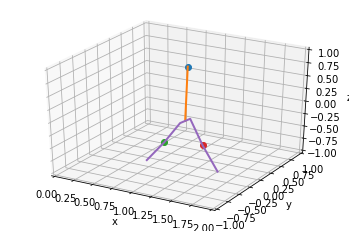

In [118]:
anim1 = Animate(h1.Z[:,:14])
anim1.set_equations(p1.P_h_num,p1.P_rh_num,p1.P_rk_num, p1.P_ra_num, p1.P_lh_num, p1.P_lk_num, p1.P_la_num)
anim1.save_video()